# drafts of possible visualizations for UI
This notebook contains draft functions for potentially useful visualizations for users
of the piecewise linear regression model.

In [53]:
import psycopg2
import pandas as pd
import numpy as np

import pickle
from collections import defaultdict

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'
import seaborn as sns

Open a list of who (handle) solved which problems (contest_id = cid, problem_id = pid) on all of codeforces

In [2]:
with open('handle_cid_pid_keys.txt') as f:
    keys = [l.strip().split(',') for l in f.readlines()]

In [443]:
db = 'codeforces'
usr = 'Joy'
con = psycopg2.connect(database=db, user=usr)

## People who improved vs those who didn't

The idea is to split users into different groups by rating blocks. Here we are using codeforces designations of user types (gray, green, teal, etc), so there are some rather verbose lines defining these categories.

Ex. green people who never got to blue vs. green people who eventually got to blue

In [120]:
cutoffs = { 
        'gray'      : [0, 1199],
        'green'     : [1200, 1399],
        'teal'      : [1400, 1599],
        'lowblue'   : [1600, 1799],
        'blue'      : [1700, 1899],
        'lowpurple' : [1900, 2099],
        'purple'    : [2000, 2199],
        'yellow'    : [2200, 2399],
        'red'       : [2400, 5000]
        }

In [ ]:
lo = 0
hi = 1000
handlecolorgroups = {}
for k, v in cutoffs.iteritems():
    handlecolorgroups[k] = pd.read_sql("""
    SELECT * FROM
        (
            SELECT handle, COUNT(*) FROM user_rating_smooth
                WHERE
                    smoothed_3months >= %d
                    AND
                    smoothed_3months <= %d
            GROUP BY handle
            HAVING COUNT(*) >= 5
        ) as a
        INNER JOIN
        (
            SELECT handle, COUNT(*) FROM user_rating_smooth
                WHERE
                    smoothed_3months >= %d
                    AND
                    smoothed_3months <= %d
            GROUP BY handle
            HAVING COUNT(*) >= 5
        ) as b;

    """ % (lo, hi, lo, hi), con)


In [122]:
gray = set(handlecolorgroups['gray'].handle)
green = set(handlecolorgroups['green'].handle)
teal = set(handlecolorgroups['teal'].handle)
lowblue = set(handlecolorgroups['lowblue'].handle)
blue = set(handlecolorgroups['blue'].handle)
lowpurple = set(handlecolorgroups['lowpurple'].handle)
purple = set(handlecolorgroups['purple'].handle)
yellow = set(handlecolorgroups['yellow'].handle)
red = set(handlecolorgroups['red'].handle)

improved users

In [123]:
gray_imp = gray.intersection(green)
green_imp = green.intersection(teal)
teal_imp = teal.intersection(blue)
blue_imp = blue.intersection(purple)
lowblue_imp = blue.intersection(purple)
lowpurple_imp = lowpurple.intersection(yellow)
purple_imp = purple.intersection(yellow)
yellow_imp = yellow.intersection(red)

users who did not improve

In [126]:
gray_non = gray.difference(gray_imp)
green_non = green.difference(green_imp)
teal_non = teal.difference(teal_imp)
lowblue_non = lowblue.difference(lowblue_imp)
blue_non = blue.difference(blue_imp)
lowpurple_non = lowpurple.difference(lowpurple_imp)
purple_non = purple.difference(purple_imp)
yellow_non = yellow.difference(yellow_imp)

In [127]:
non = [(len(gray_non) + 0.0) / len(gray),
       (len(green_non) + 0.0) / len(green),
       (len(teal_non) + 0.0) / len(teal),
       (len(lowblue_non) + 0.0) / len(lowblue),
       (len(blue_non) + 0.0) / len(blue),
       (len(lowpurple_non) + 0.0) / len(lowpurple),
       (len(purple_non) + 0.0) / len(purple),
       (len(yellow_non) + 0.0) / len(yellow)
      ]

imp = [(len(gray_imp) + 0.0) / len(gray),
       (len(green_imp) + 0.0) / len(green),
       (len(teal_imp) + 0.0) / len(teal),
       (len(lowblue_imp) + 0.0) / len(lowblue),
       (len(blue_imp) + 0.0) / len(blue),
       (len(lowpurple_imp) + 0.0) / len(lowpurple),
       (len(purple_imp) + 0.0) / len(purple),
       (len(yellow_imp) + 0.0) / len(yellow)
      ]


Looking at "transition" probabilities from one rank to the next, we see that this is pretty much what we would expect given the shape of user rating distributions.

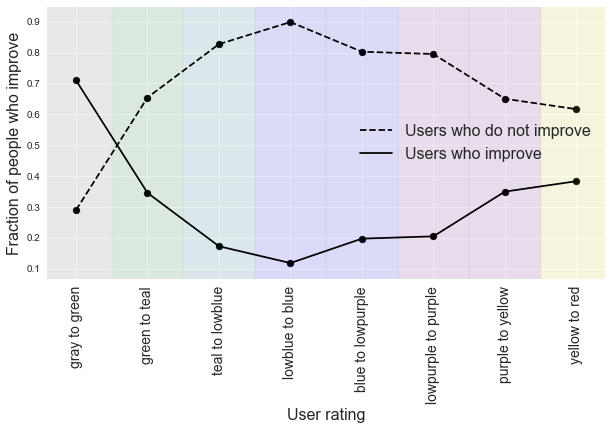

In [130]:
colors = { 
        'gray'  : 'gray',
        'green' : 'green',                                                                                                            
        'teal'  : 'teal',
        'blue'  : 'blue',
        'purple': 'purple',
        'yellow': 'yellow',
        'red'   : 'red'
        }


plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.plot(non, ls="--", c="0")
plt.scatter(range(len(non)), non, c='0')
plt.plot(imp, c='0')
plt.scatter(range(len(imp)), imp, c='0')
plt.ylabel("Fraction of people who improve", fontsize = 16)
plt.xlabel("User rating", fontsize = 16)
ax = plt.gca()
plt.legend(["Users who do not improve", "Users who improve"], fontsize = 16)
import matplotlib.patches as patches
ax.add_patch( patches.Rectangle( (-.5, 0), 1, 2, alpha=0.1, color=colors['gray']) )
ax.add_patch( patches.Rectangle( (.5, 0), 1, 2, alpha=0.1, color=colors['green']) )
ax.add_patch( patches.Rectangle( (1.5, 0), 1, 2, alpha=0.1, color=colors['teal']) )
ax.add_patch( patches.Rectangle( (2.5, 0), 1, 2, alpha=0.1, color=colors['blue']) )
ax.add_patch( patches.Rectangle( (3.5, 0), 1, 2, alpha=0.1, color=colors['blue']) )
ax.add_patch( patches.Rectangle( (4.5, 0), 1, 2, alpha=0.1, color=colors['purple']) )
ax.add_patch( patches.Rectangle( (5.5, 0), 1, 2, alpha=0.1, color=colors['purple']) )
ax.add_patch( patches.Rectangle( (6.5, 0), 1, 2, alpha=0.1, color=colors['yellow']) )

x = range(len(non))
labels=['gray to green',
        'green to teal',
        'teal to lowblue',
        'lowblue to blue',
        'blue to lowpurple',
        'lowpurple to purple',
        'purple to yellow',
        'yellow to red']
plt.xticks(x, labels, rotation='vertical', fontsize=14)

#ax.patch.set_facecolor('white')
ax.patch.set_alpha(.5)

## Model visualizations

In [448]:
import pickle
with open('ols_models_final.pickle') as f:
    m = pickle.load(f)

df_coef = m['df_coef']

In [452]:
m.keys()

['models', 'df_coef', 'variables', 'bins', 'xmax']

```sig_coef``` are coefficients that remained in at least one model after elastic net regularization

In [304]:
sig_coef = df_coef[m['variables']]

In [306]:
for c in sig_coef.columns:
    print c

java
lowlevel
max_probability_contest
max_timediff
mean_probability_contest
mean_probability_practice
python
smoothed_3months
std_probability_contest
std_probability_practice
tot_solvetime
unique_tags_total
time_between_mean
time_between_std
log_max_probability_practice
log_mean_probability_practice
log_std_probability_contest
log_std_probability_practice
exp_max_probability_contest
exp_max_probability_practice
exp_mean_probability_practice
exp_performance
exp_rank
exp_std_probability_practice
tanh_java
tanh_lowlevel
tanh_max_probability_contest
tanh_max_ratingdiff_practice
tanh_max_solvetime
tanh_max_timediff
tanh_mean_ratingdiff_practice
tanh_n100
tanh_oldrating
tanh_python
tanh_smoothed_3months
tanh_std_probability_contest
tanh_std_probability_practice
tanh_std_ratingdiff_contest 
tanh_std_ratingdiff_practice
tanh_std_timediff
tanh_tot_solvetime
tanh_total_problems
tanh_unique_newtags
tanh_unique_tags_total
tanh_binary search
tanh_bitmasks
tanh_combinatorics
tanh_constructive algori

Since ```n_contest``` appears in various forms, let's visualize what it actually looks like in our model

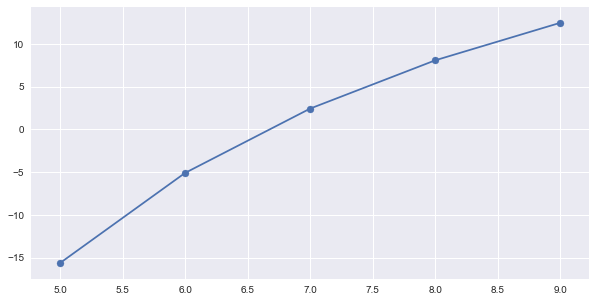

In [361]:
group = 1
x = np.arange(5, 10)
y = df_coef.tanh_n_contest[group] * np.tanh(x) + df_coef.inv_total_contests[group] * 1.0/x + df_coef.inv_n_contest[group] * 1.0/x
y *= 532.75
plt.plot(x, y)
plt.scatter(x, y)

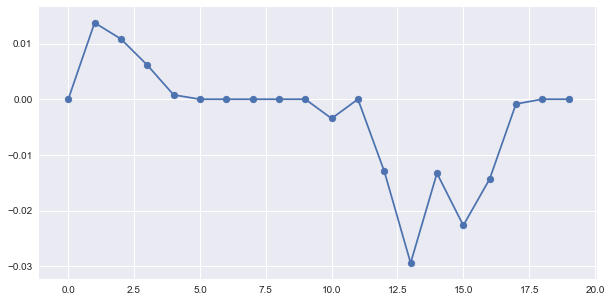

In [329]:
var = 'max_probability_contest'
plt.plot(sig_coef[var])
plt.scatter(range(sig_coef.shape[0]), sig_coef[var])

Test out what the model looks like for a user with rating 2000

In [262]:
usr_rate = 2000
idx = np.logical_and(df_coef['binlow'] <= usr_rate, df_coef['binhigh'] > usr_rate)

In [269]:
df_coef.reset_index(drop=True, inplace=True)

In [272]:
test = df_coef.loc[np.where(idx)[0][0], :]
test.is_copy = False
test.drop(['binhigh', 'binlow'], inplace=True)
sortkey = test.abs().sort_values(ascending=False).index

test = test[sortkey]
test = test[test != 0]
q = """
select tag from all_tags
"""
all_tags = pd.read_sql(q, con)['tag']
all_tags = set(all_tags)

Which tags are important? What does their total contribution (including nonlinear transformations) look like?

In [252]:
tag_coefs = []
for t in test.index:
    for a in all_tags:
        if a in t and round(test[t]*532.75) != 0:
            tag_coefs.append((t, round(test[t]*532.75)))
            
tag_coefs

[('inv_hashing', 2.0),
 ('inv_geometry', 1.0),
 ('inv_graphs', 1.0),
 ('inv_data structures', 1.0),
 ('inv_combinatorics', -1.0),
 ('inv_constructive algorithms', 1.0),
 ('inv_dsu', 1.0),
 ('inv_math', 1.0),
 ('inv_dp', 1.0)]

In [275]:
X = pd.read_csv('OLStrain_all_normalized_data.csv')

In [278]:
xmax = np.max(X, axis=0)

In [280]:
with open('OLS_xmax.pickle', 'w') as f:
    pickle.dump(xmax, f)

In [276]:
xmax = np.max(np.array(X), axis=0)

In [277]:
len(xmax)

457

In [389]:
vardict = defaultdict(list)

mods = ['tanh_', 'log_', 'exp_', 'inv_']
for c in df_coef.columns:
    #if not any([t in c for t in all_tags]): # if not a tag
    found = False
    for t in mods:
        if t in c:
            stem = c.replace(t, '')
            vardict[stem].append(t)
            found = True
    if not found:
        vardict[c].append("")

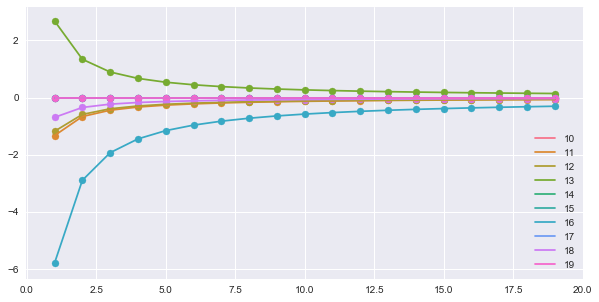

In [441]:
with sns.color_palette("husl", 10):
    for group in range(10, 20):
        name = 'n_solved'

        vardict[name]
        nx = 20
        x = np.arange(1, nx)
        y = np.zeros(nx-1)
        for v in vardict[name]:
            coef = df_coef[v + name][group]
            if v == "tanh_":
                y += np.tanh(x) * coef
            if v == "exp_":
                y += np.exp(x) * coef
            if v == "log_":
                y += np.log(x) * coef
            if v == "inv_":
                y += 1.0/x * coef
            if v == "":
                y += x * coef

        y *= 532.75
        plt.plot(x, y)
        plt.scatter(x, y)
plt.legend(range(10, 20))